In [25]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from multiprocessing import Pool

NUM_THREADS = 4

p = Pool(NUM_THREADS)

In [27]:
num_list = np.arange(8).tolist()
num_list

[0, 1, 2, 3, 4, 5, 6, 7]

In [28]:
def fun(x):
    return x**2

In [29]:
p.map(fun, num_list)

[0, 1, 4, 9, 16, 25, 36, 49]

In [30]:
p.close()

In [31]:
index = np.arange(NUM_THREADS).tolist()

In [64]:
# Get data_df and symbol
total_data_df = pd.read_pickle('../../data/data_df.pkl')
SYMBOL = 'AAPL'
data_df = total_data_df[SYMBOL].unstack()

In [65]:
import recommender.simulator as sim
from utils.analysis import value_eval

In [98]:
from recommender.agent import Agent

# Create many agents
env, num_states, num_actions = sim.initialize_env(data_df, SYMBOL)
#for...
agents = [Agent(num_states=num_states, 
                num_actions=num_actions, 
                random_actions_rate=0.98, 
                random_actions_decrease=0.999,
                dyna_iterations=20) for i in index]

In [99]:
agents

In [45]:
single_agent = Agent(num_states=num_states, 
                num_actions=num_actions, 
                random_actions_rate=0.98, 
                random_actions_decrease=0.999,
                dyna_iterations=20)
%timeit sim.simulate_period(data_df, SYMBOL, single_agent)

Starting simulation
Iteration 6000/6024Starting simulation
Iteration 6000/6024Starting simulation
Iteration 6000/6024Starting simulation
Iteration 6000/60241 loop, best of 3: 2min 47s per loop


In [ ]:
# Simulate (with new envs, each time) in parallel
from multiprocessing import Pool
from functools import partial

data_in_df = data_df.iloc[-500:]

NUM_THREADS = 4

p = Pool(NUM_THREADS)

tic = time()
results_list = p.map(partial(sim.simulate_period, data_in_df, SYMBOL), agents)
toc = time()
print('Elapsed time: {} seconds.'.format((toc-tic)))

Starting simulation for agent: <recommender.agent.Agent object at 0x7f8377f34cf8>
Starting simulation for agent: <recommender.agent.Agent object at 0x7f8377b8c048>
Starting simulation for agent: <recommender.agent.Agent object at 0x7f8377b8ce48>
Starting simulation for agent: <recommender.agent.Agent object at 0x7f839ce3f9e8>


Sharpe ratio: -0.4916806276466048
Cum. Ret.: -0.21070600000000017
AVG_DRET: -0.0003936231127640644
STD_DRET: 0.012708601577152742
Final value: 7892.939999999999
----------------------------------------------------------------------------------------------------
Sharpe ratio: 0.28577087118601235
Cum. Ret.: 0.08238900000000071
AVG_DRET: 0.00027171535360848533
STD_DRET: 0.015093727014145377
Final value: 10823.890000000007
----------------------------------------------------------------------------------------------------
Sharpe ratio: -0.41744190324426583
Cum. Ret.: -0.20383399999999952
AVG_DRET: -0.00036177243299321914
STD_DRET: 0.013757505628352143
Final value: 7961.660000000004
----------------------------------------------------------------------------------------------------
Sharpe ratio: -0.16230422272686945
Cum. Ret.: -0.11248100000000105
AVG_DRET: -0.00014209495928358152
STD_DRET: 0.013897898101623476
Final value: 8875.18999999999
--------------------------------------------------

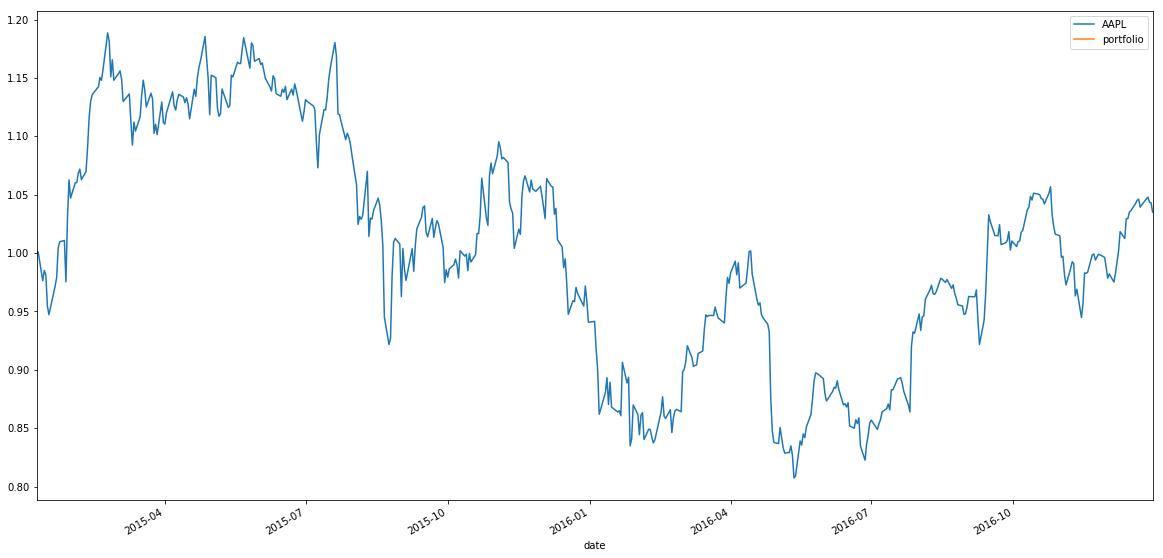

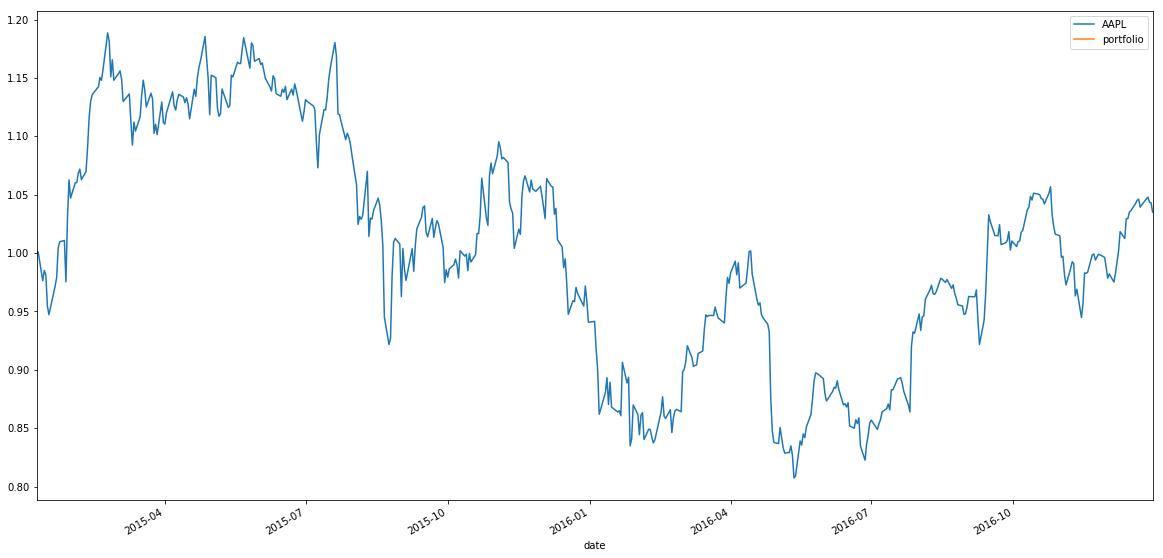

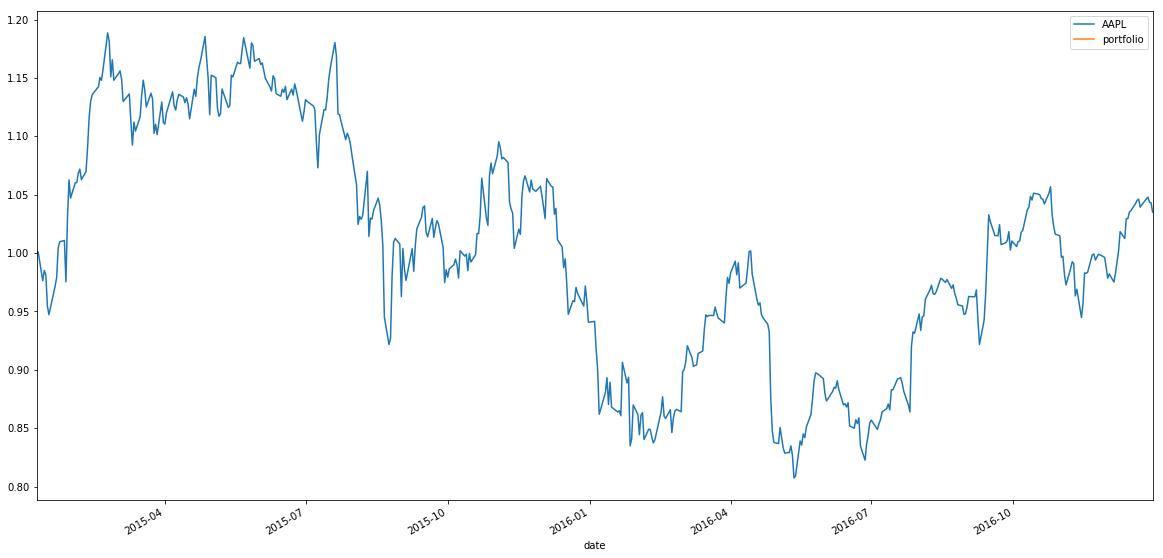

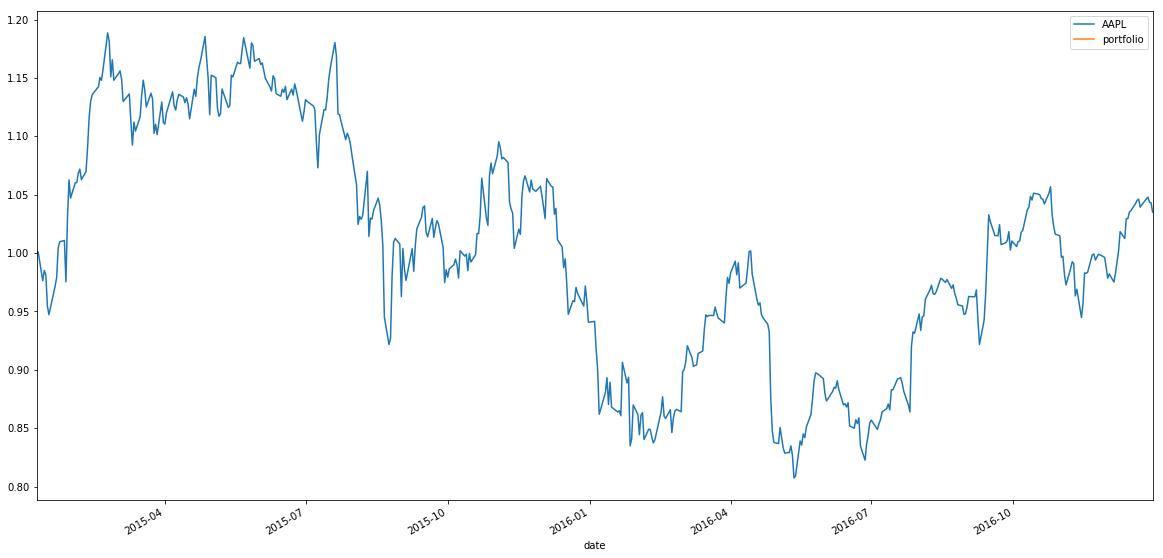

In [109]:
for values in results_list:
    total_value = values.sum(axis=1)
    print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
    print('-'*100)
    initial_date = total_value.index[0]
    compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
    compare_results.name='AAPL'
    compare_results_df = pd.DataFrame(compare_results)
    compare_results_df['portfolio'] = total_value
    std_comp_df = compare_results_df / compare_results_df.iloc[0]
    plt.figure()
    std_comp_df.plot()

In [107]:
# Try to combine the agents' information
agents[1].QExplore.max()

1.0

In [79]:
# Try to combine the agents' information
q_mean = np.array([agents[i].Q for i in range(len(agents))]).mean(axis=0)
for agent in agents:
    agent.Q = q_mean

In [94]:
p.close()